In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
from pandas import DataFrame
import urllib.parse
import datetime as dt
from tqdm import tqdm
from time import sleep

In [2]:
def get_playercount(appid: int = 730) -> dict:
    """
    Extracts current playercount from Steam API and 24-hour and all-time peak from steamcharts.com

    Parameters:
        appid (int): Steam appid. Defaults to 730 (CS:GO)
    Returns:
        dict: A dictionary with the current playercount, 24-hour peak and all-time peak
    """
    page = requests.get(
        f'https://steamcharts.com/app/{appid}')
    soup = BeautifulSoup(page.content, 'lxml')
    tag = soup.find('div', id='app-heading')
    tags = tag.find_all('div', class_="app-stat")
    result = {}
    result['24-hour peak'] = int(tags[1].find('span').string)
    result['All-time peak'] = int(tags[2].find('span').string)
    response = requests.get(
        f'https://api.steampowered.com/ISteamUserStats/GetNumberOfCurrentPlayers/v1/?appid={appid}')
    result['Playercount'] = response.json().get(
        'response', {}).get('player_count', 0)
    return result


In [3]:
get_playercount()


{'24-hour peak': 1340754, 'All-time peak': 1519457, 'Playercount': 990333}

In [4]:
def get_unboxing_numbers() -> DataFrame:
    """
    Extracts unboxing numbers from csgocasetracker.com

    Returns:
        DataFrame: A dataframe with total, monthly, weekly and daily unboxing number for every case
    """
    daily_response = requests.get(
        'https://csgocasetracker.com/calculations/calcDaily.csv')
    daily_csv = StringIO(daily_response.content.decode('utf-8'))
    weekly_response = requests.get(
        'https://csgocasetracker.com/calculations/calcWeekly.csv')
    weekly_csv = StringIO(weekly_response.content.decode('utf-8'))
    monthly_response = requests.get(
        'https://csgocasetracker.com/calculations/calculation.csv')
    monthly_csv = StringIO(monthly_response.content.decode('utf-8'))
    total_response = requests.get(
        'https://csgocasetracker.com/calculations/calculationTotal.csv')
    total_csv = StringIO(total_response.content.decode('utf-8'))
    daily_df = pd.read_csv(daily_csv, sep=',')
    weekly_df = pd.read_csv(weekly_csv, sep=',')
    monthly_df = pd.read_csv(monthly_csv, sep=',')
    total_df = pd.read_csv(total_csv, sep=',')
    result = pd.DataFrame()
    result['Case Name'] = total_df['Case Name']
    result['Total Unboxing Number'] = total_df['Unboxing Number']
    result['Monthly Unboxing Number'] = monthly_df['Unboxing Number']
    result['Weekly Unboxing Number'] = weekly_df['Unboxing Number']
    result['Daily Unboxing Number'] = daily_df['Unboxing Number']
    return result


In [5]:
get_unboxing_numbers()


,Case Name,Total Unboxing Number,Monthly Unboxing Number,Weekly Unboxing Number,Daily Unboxing Number
0,CS:GO Weapon Case,4627384,18769,3230,461
1,eSports 2013 Case,3059692,8461,1384,461
2,Operation Bravo Case,3684651,7177,2392,0
3,CS:GO Weapon Case 2,4168091,21937,0,0
4,eSports 2013 Winter Case,7644634,27160,3133,0
5,Winter Offensive Weapon Case,14043692,44029,5503,786
6,CS:GO Weapon Case 3,4011396,21937,3133,0
7,Operation Phoenix Weapon Case,54915894,521640,90720,22680
8,Huntsman Weapon Case,23791756,78974,26324,8774
9,Operation Breakout Weapon Case,60124740,423360,52920,22680


In [6]:
def get_price_history(item_name: str) -> DataFrame:
    """
    Extracts price history for a CS:GO/CS2 item from Steam

    Parameters:
        item_name(str): Name of the CS:GO/CS2 item on Steam Community Market
    Returns:
        DataFrame: A dataframe with price history containing datetimes, prices and amount sold for the given item
    """

    url = f"https://steamcommunity.com/market/listings/730/{urllib.parse.quote(item_name)}"
    response = requests.get(url).text
    response = response[response.find("line1")+6:]
    response = response[0:response.find("]];")+2]

    price_list = eval(response)
    month_list = [None,
                  'Jan',
                  'Feb',
                  'Mar',
                  'Apr',
                  'May',
                  'Jun',
                  'Jul',
                  'Aug',
                  'Sep',
                  'Oct',
                  'Nov',
                  'Dec']
    for i, entry in enumerate(price_list):
        # Date and time
        date_time = entry[0]
        date_time = date_time.split(" ")
        month = month_list.index(date_time[0])
        day = int(date_time[1])
        year = int(date_time[2])
        hour = int(date_time[3].split(":")[0])
        date_time = dt.datetime(
            year, month, day, hour=hour, minute=0, second=0)

        # Price
        price = float(entry[1])

        # Amount sold
        sold = int(entry[2])

        # compile dictionary and add it back to the list
        price_dict = {
            "Date": date_time,
            "Price(USD)": price,
            "Amount sold": sold
        }
        price_list[i] = price_dict

    df = pd.DataFrame.from_dict(price_list)

    return df


In [7]:
price_history = get_price_history('Dreams & Nightmares Case')
price_history


,Date,Price(USD),Amount sold
0,2022-01-21 01:00:00,10.675,76680
1,2022-01-22 01:00:00,6.173,70330
2,2022-01-23 01:00:00,4.914,62767
3,2022-01-24 01:00:00,4.328,52950
4,2022-01-25 01:00:00,3.996,51942
...,...,...,...
1170,2023-04-29 05:00:00,1.850,5068
1171,2023-04-29 06:00:00,1.860,5626
1172,2023-04-29 07:00:00,1.850,4524
1173,2023-04-29 08:00:00,1.821,3925


<AxesSubplot:xlabel='Date'>

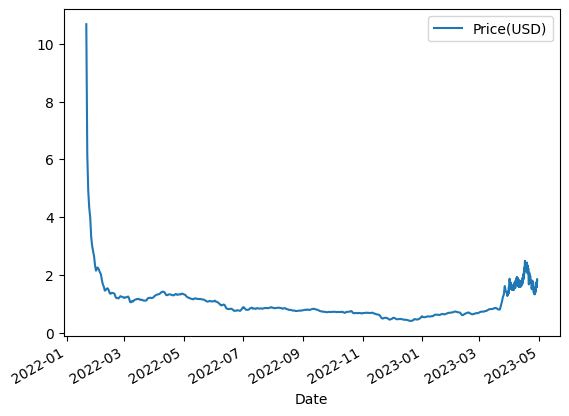

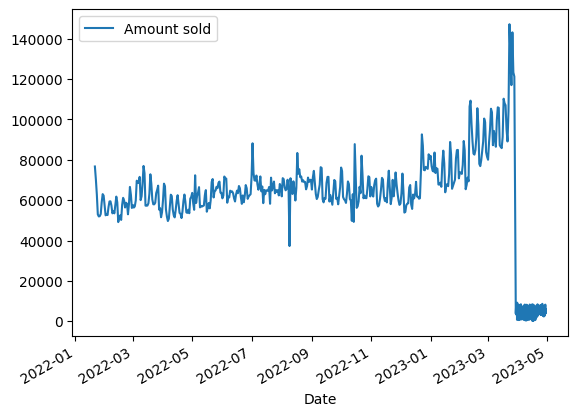

In [8]:
price_history.plot(x='Date', y='Price(USD)', rot=30)
price_history.plot(x='Date', y='Amount sold', rot=30)


In [9]:
def smoothen_price_history(df: DataFrame) -> DataFrame:
    """
    Aggregates hourly values for the past month into daily values so that time gaps between all values are consistent

    Parameters:
        DataFrame: A dataframe with price history acquired from price_history()
    Returns:
        DataFrame: A dataframe with price history with average daily prices and total daily amounts sold for the last month
    """
    df_copy = df.copy()
    df_copy['Date'] = df_copy['Date'].apply(lambda x: x.date())
    df_copy = df_copy.groupby('Date', as_index=False).agg(
        {'Price(USD)': 'mean', 'Amount sold': 'sum'})
    return df_copy


In [10]:
smooth_price_history = smoothen_price_history(price_history)
smooth_price_history


,Date,Price(USD),Amount sold
0,2022-01-21,10.675000,76680
1,2022-01-22,6.173000,70330
2,2022-01-23,4.914000,62767
3,2022-01-24,4.328000,52950
4,2022-01-25,3.996000,51942
...,...,...,...
459,2023-04-25,1.562833,141261
460,2023-04-26,1.432083,118334
461,2023-04-27,1.498625,119707
462,2023-04-28,1.654083,123486


<AxesSubplot:xlabel='Date'>

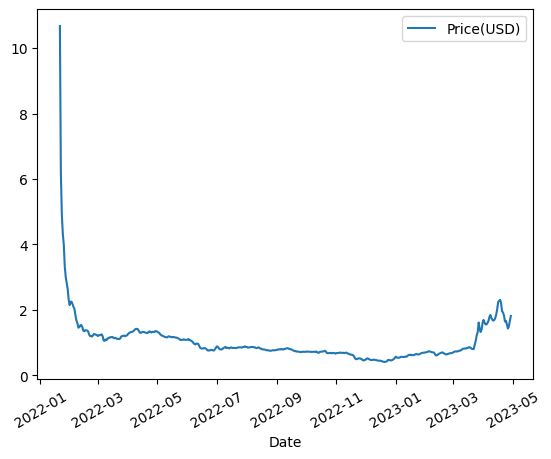

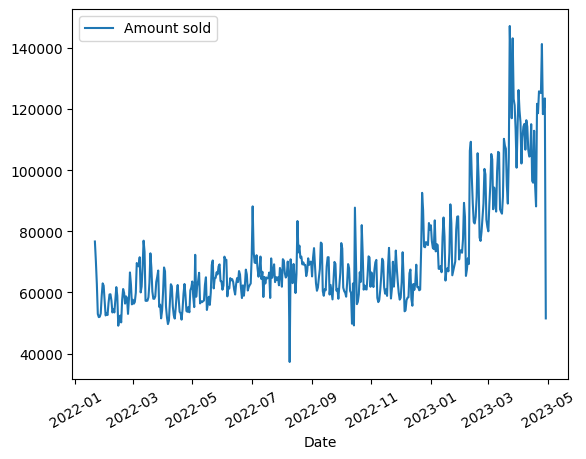

In [11]:
smooth_price_history.plot(x='Date', y='Price(USD)', rot=30)
smooth_price_history.plot(x='Date', y='Amount sold', rot=30)


In [12]:
def get_smooth_price_history(item_name: str) -> DataFrame:
    """
    Extracts price history for a CS:GO/CS2 item from Steam with values from the last month aggregated to have daily instead of hourly data

    Parameters:
        item_name(str): Name of the CS:GO/CS2 item on Steam Community Market
    Returns:
        DataFrame: A dataframe with price history containing dates, prices and amount sold for the given item
    """
    return smoothen_price_history(get_price_history(item_name))


In [13]:
smooth_price_history2 = get_smooth_price_history('Recoil Case')
smooth_price_history2


,Date,Price(USD),Amount sold
0,2022-07-01,18.725000,6647
1,2022-07-02,9.067000,65281
2,2022-07-03,6.088000,55152
3,2022-07-04,4.924000,50299
4,2022-07-05,4.465000,51490
...,...,...,...
298,2023-04-25,1.018042,122254
299,2023-04-26,0.895500,101815
300,2023-04-27,0.982375,106496
301,2023-04-28,1.091042,106135


<AxesSubplot:xlabel='Date'>

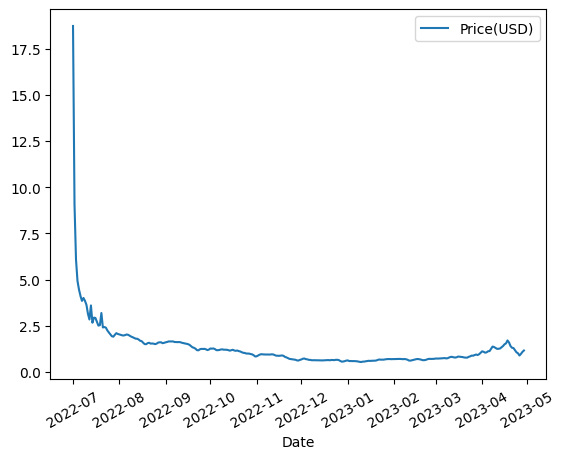

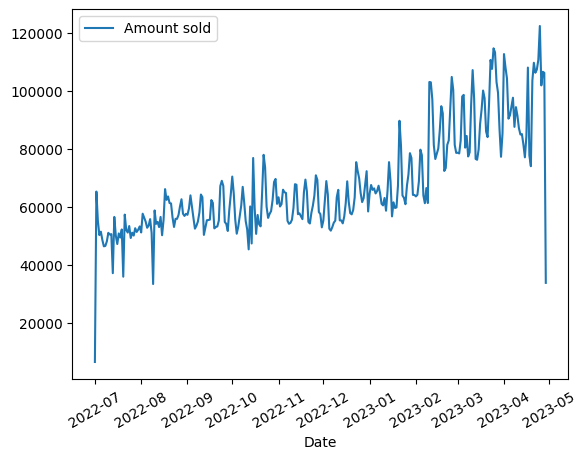

In [14]:
smooth_price_history2.plot(x='Date', y='Price(USD)', rot=30)

smooth_price_history2.plot(x='Date', y='Amount sold', rot=30)


In [15]:
def get_price_history_for_multiple(item_list: list[str], smoothen: bool = True, delay: int = 15) -> tuple[DataFrame, DataFrame]:
    """
    Extracts price history for a list of CS:GO/CS2 items from Steam

    Parameters:
        item_list(list[str]): Name of the CS:GO/CS2 item on Steam Community Market
        smoothen(bool): If True hourly values for the past month are aggregated into daily values so that time gaps between all values are consistent. Defaults to True
        delay(int): The delay between requests to Steam Community Market in seconds. Defaults to 15
    Returns:
        tuple[DataFrame, DataFrame]: A list containing two dataframes (amount sold history and price history) for the given list of items
    """
    
    df_list = []
    print("Getting info might take a while because of Steam rate limits")
    print("If this process fails, consider changing the delay between requests by setting the 'delay' parameter")
    print(f"Current delay is {delay} seconds")
    for item in tqdm(item_list):
        price_history = get_price_history(item)
        if smoothen:
            price_history = smoothen_price_history(price_history)
        df_list.append(price_history)
        sleep(delay)

    # Compile prices
    prices_df = pd.DataFrame()

    for item, df in zip(item_list, df_list):
        item_prices = df[['Date', 'Price(USD)']].copy()
        item_prices.rename(columns={'Price(USD)': item}, inplace=True)

        if prices_df.empty:
            prices_df = item_prices
        else:
            prices_df = prices_df.merge(item_prices, on='Date', how='outer')

    # Compile amounts sold
    amounts_df = pd.DataFrame()

    for item, df in zip(item_list, df_list):
        item_amounts = df[['Date', 'Amount sold']].copy()
        item_amounts.rename(columns={'Amount sold': item}, inplace=True)

        if amounts_df.empty:
            amounts_df = item_amounts
        else:
            amounts_df = amounts_df.merge(item_amounts, on='Date', how='outer')
    
    return prices_df, amounts_df

In [31]:
def get_historical_monthly_unboxing_numbers() -> DataFrame:
    """
    Extracts historical monthly unboxing numbers from csgocasetracker.com

    Returns:
        DataFrame: A dataframe with historical monthly unboxing numbers for every case
    """
    # Extracting stats
    csv_ids = ['january2022', 'february2022', 'march2022', 'april2022', 'may2022', 'june2022',
               'july2022', 'august2022', 'september2022', 'october2022', 'november2022',
               'december2022', 'january2023', 'february2023', 'march2023']
    df_list = []
    for id in csv_ids:
        response = requests.get(
            f'https://csgocasetracker.com/calculations/previousCalc/{id}.csv')
        csv = StringIO(response.content.decode('utf-8'))
        df = pd.read_csv(csv, sep=',')
        df_list.append(df)

    # Add a new column 'Month' in each dataframe to represent the month based on its position in the list
    for i, df in enumerate(df_list):
        df['Month'] = i + 1

    # Drop useless columns and merge the data
    df_list = [df[['Month', 'Case Name', 'Unboxing Number']] for df in df_list]
    df_concatenated = pd.concat(df_list)
    df_pivoted = df_concatenated.pivot(
        index='Case Name', columns='Month', values='Unboxing Number')
    df_pivoted.reset_index(inplace=True)

    # Make the cases to go in original order instead of alphabetical order
    case_names_order = df_list[-1]['Case Name'].values
    df_pivoted = df_pivoted.sort_values(by='Case Name', key=lambda x: x.map(
        {case: i for i, case in enumerate(case_names_order)}))

    df_pivoted.reset_index(drop=True, inplace=True)
    df_pivoted.fillna(0, inplace=True)
    df_transposed = df_pivoted.set_index('Case Name').transpose()
    df_transposed.index.name = None

    # Add a 'Month' column with month and year values as dates
    start_month = dt.date(2022, 1, 1)
    df_transposed['Month'] = [start_month +
                              pd.DateOffset(months=i) for i in range(len(df_transposed))]

    # Move the 'Month' column to be the first column in the dataframe
    cols = df_transposed.columns.tolist()
    cols = ['Month'] + cols[:-1]
    df_transposed = df_transposed[cols]

    return df_transposed


In [17]:
def montly_unboxing_numbers_to_daily(df: DataFrame) -> DataFrame:
    """
    Converts monthly historical unboxing numbers into daily numbers.

    Parameters:
        df(DataFrame): A dataframe with montly unboxing numbers acquired from get_historical_monthly_unboxing_numbers()
    Returns:
        DataFrame: A dataframe with historical daily unboxing numbers
    """
    df_result = df.copy()

    df_result['Month'] = pd.to_datetime(df_result['Month'])

    # Set 'Month' column as the index to use days_in_month attribute
    df_result.set_index('Month', inplace=True)
    df_result['Days in Month'] = df_result.index.days_in_month

    # Rescale values
    for col in df_result.columns[:-1]:
        df_result[col] = df_result[col] / df_result['Days in Month']
    df_result.drop('Days in Month', axis=1, inplace=True)

    # Expand the values so there's data for every day of each month and not only for the first day
    # These four lines are here so that we do not exclude the last month when filling in values
    last_date = df_result.index[-1]
    last_row = df_result.iloc[-1]
    last_row.name = last_date + pd.offsets.MonthEnd(0)
    df_result = pd.concat([df_result, pd.DataFrame(
        [last_row], columns=df_result.columns)])

    df_result = df_result.resample('D').ffill()

    df_result.reset_index(inplace=True)
    df_result.rename(columns={'index': 'Date'}, inplace=True)
    return df_result


In [18]:
def unboxing_moving_average(df: DataFrame, n: int = 30) -> DataFrame:
    """
    Applies a moving average to daily unboxing numbers 

    Parameters:
        df(DataFrame): A dataframe with daily unboxing numbers acquired from montly_unboxing_numbers_to_daily()
        n(int): Amount of days for the moving average. Defaults to 30
    Returns:
        DataFrame: A dataframe with smoothed historical daily unboxing numbers
    """
    df_ma = df.copy()
    df_ma.set_index('Date', inplace=True)
    df_ma = df_ma.rolling(f'{n}D').mean()
    df_ma.reset_index(inplace=True)
    return df_ma


In [19]:
def get_historical_daily_unboxing_numbers(n: int = 30) -> DataFrame:
    """
    Extracts historical monthly unboxing numbers from csgocasetracker.com, rescales them to
    get daily numbers and applies a moving average if needed.

    Parameters:
        n(int): Amount of days for the moving average. Defaults to 30
    Returns:
        DataFrame: A dataframe with historical daily unboxing numbers for every case
    """
    df = get_historical_monthly_unboxing_numbers()
    df = montly_unboxing_numbers_to_daily(df)
    df = unboxing_moving_average(df, n)
    return df


In [20]:
get_historical_monthly_unboxing_numbers()


Case Name,Month,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
1,2022-01-01,23231.0,9846.0,19141.0,20370.0,26116.0,24373.0,6268.0,378000.0,64349.0,...,241920.0,104463.0,1525166.0,1967865.0,1259259.0,2051282.0,3063628.0,733143.0,0.0,0.0
2,2022-02-01,20923.0,6154.0,11963.0,9402.0,16714.0,22015.0,17236.0,219240.0,35100.0,...,226800.0,87369.0,1635328.0,2094649.0,1160494.0,2106363.0,2491928.0,1565052.0,0.0,0.0
3,2022-03-01,19846.0,9385.0,4785.0,12536.0,15670.0,25946.0,23504.0,309960.0,38025.0,...,340200.0,119658.0,1698006.0,2502893.0,1297246.0,2888889.0,2093067.0,2260209.0,0.0,0.0
4,2022-04-01,21077.0,6615.0,7178.0,14103.0,28205.0,28304.0,20370.0,347760.0,29250.0,...,241920.0,112061.0,1726496.0,2244841.0,1183286.0,2807217.0,1221273.0,2345679.0,0.0,0.0
5,2022-05-01,13846.0,5385.0,9571.0,10969.0,13580.0,35380.0,20370.0,272160.0,29250.0,...,173880.0,87369.0,1728395.0,2330318.0,1171890.0,2830009.0,850902.0,2184236.0,0.0,0.0
6,2022-06-01,17538.0,5231.0,11963.0,6268.0,27160.0,25946.0,25071.0,226800.0,23400.0,...,204120.0,79772.0,1530864.0,1893998.0,793922.0,2410256.0,493827.0,2351377.0,0.0,0.0
7,2022-07-01,15846.0,6154.0,7178.0,10969.0,13580.0,25159.0,14103.0,325080.0,64349.0,...,234360.0,96866.0,1726496.0,2487619.0,649573.0,2695157.0,450142.0,2763533.0,1518063.0,0.0
8,2022-08-01,17692.0,4154.0,9571.0,12536.0,9402.0,30663.0,10969.0,204120.0,29250.0,...,302400.0,72175.0,1582146.0,2692918.0,676163.0,2763533.0,402659.0,2723647.0,2044558.0,0.0
9,2022-09-01,14769.0,5538.0,9571.0,20370.0,18803.0,29091.0,14103.0,226800.0,35100.0,...,204120.0,83571.0,1460589.0,2327366.0,592593.0,2535613.0,385565.0,3012346.0,2380931.0,0.0
10,2022-10-01,15538.0,4462.0,4785.0,10969.0,12536.0,24373.0,6268.0,181440.0,29250.0,...,264600.0,70275.0,1061728.0,1991956.0,442545.0,2049383.0,260209.0,2693257.0,2082583.0,0.0


In [21]:
get_historical_daily_unboxing_numbers(n=30)


Case Name,Date,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
0,2022-01-01,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
1,2022-01-02,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
2,2022-01-03,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
3,2022-01-04,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
4,2022-01-05,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,2023-03-27,767.847350,339.767972,450.936636,772.635599,893.932373,1615.664977,573.150000,13036.645161,1653.876498,...,13151.612903,2980.059447,68085.234217,129964.602995,14182.637097,119314.350576,7199.503111,167044.535023,139056.997811,81689.985945
451,2023-03-28,774.919739,347.264670,454.979263,784.671045,910.460292,1626.626114,567.433333,12999.483871,1668.702611,...,13238.709677,2987.426728,68835.704531,130700.638556,14172.790323,120429.663825,7229.991321,168138.840553,139881.697465,82909.162673
452,2023-03-29,781.992127,354.761367,459.021889,796.706490,926.988210,1637.587250,561.716667,12962.322581,1683.528725,...,13325.806452,2994.794009,69586.174846,131436.674117,14162.943548,121544.977074,7260.479531,169233.146083,140706.397120,84128.339401
453,2023-03-30,789.064516,362.258065,463.064516,808.741935,943.516129,1648.548387,556.000000,12925.161290,1698.354839,...,13412.903226,3002.161290,70336.645161,132172.709677,14153.096774,122660.290323,7290.967742,170327.451613,141531.096774,85347.516129


In [22]:
def update_with_recent_daily_numbers(df: DataFrame) -> DataFrame:
    """
    Updates historical daily unboxing numbers from csgocasetracker.com with recent values.

    Parameters:
        df(DataFrame): A dataframe with historical daily unboxing numbers for every case acquired from get_historical_daily_unboxing_numbers() or montly_unboxing_numbers_to_daily()
    Returns:
        DataFrame: A dataframe with historical daily unboxing numbers for every case up to today
    """

    df_expanded = df.copy()
    df_expanded.set_index('Date', inplace=True)

    # Expand the dataframe to include dates up to today
    last_date = df_expanded.index[-1] + pd.Timedelta(days=1)
    today = pd.Timestamp(dt.datetime.now().date())
    days_to_today = (today - last_date).days
    date_range = pd.date_range(last_date, periods=days_to_today + 1)
    df_expansion = df_expanded.reindex(date_range)
    df_expanded = pd.concat([df_expanded, df_expansion])

    # Fill in missing values
    df_recent = get_unboxing_numbers()
    for _, row in df_recent.iterrows():
        case_name = row['Case Name']

        last_month = df_expanded.index[-1] - pd.DateOffset(months=1)
        days_in_last_month = last_month.days_in_month
        monthly_unboxing = row['Monthly Unboxing Number'] / days_in_last_month
        weekly_unboxing = row['Weekly Unboxing Number'] / 7
        daily_unboxing = row['Daily Unboxing Number']

        df_expanded.loc[df_expanded.index[-1], case_name] = daily_unboxing
        df_expanded.loc[df_expanded.index[-7]:df_expanded.index[-1],
                        case_name] = df_expanded.loc[df_expanded.index[-7]:df_expanded.index[-1], case_name].fillna(weekly_unboxing)
        df_expanded.loc[last_month:, case_name] = df_expanded.loc[last_month:, case_name].fillna(
            monthly_unboxing)

    df_expanded.reset_index(inplace=True)
    df_expanded.rename(columns={'index': 'Date'}, inplace=True)

    return df_expanded


In [23]:
update_with_recent_daily_numbers(get_historical_daily_unboxing_numbers())


Case Name,Date,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
0,2022-01-01,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
1,2022-01-02,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
2,2022-01-03,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
3,2022-01-04,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
4,2022-01-05,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2023-04-16,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286
472,2023-04-17,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286
473,2023-04-18,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286
474,2023-04-19,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286


In [24]:
df_unboxing = get_unboxing_numbers()
df_unboxing

,Case Name,Total Unboxing Number,Monthly Unboxing Number,Weekly Unboxing Number,Daily Unboxing Number
0,CS:GO Weapon Case,4623384,24307,4307,153
1,eSports 2013 Case,3057692,10615,2461,153
2,Operation Bravo Case,3682258,9570,0,0
3,CS:GO Weapon Case 2,4166524,25071,1566,0
4,eSports 2013 Winter Case,7641500,35517,9401,1044
5,Winter Offensive Weapon Case,14036616,53463,10221,0
6,CS:GO Weapon Case 3,4008262,26638,6267,0
7,Operation Phoenix Weapon Case,54810054,582120,173880,7560
8,Huntsman Weapon Case,23765432,67274,20474,0
9,Operation Breakout Weapon Case,60034020,498960,143640,15120


In [25]:
df_daily = update_with_recent_daily_numbers(get_historical_daily_unboxing_numbers(n=1))
df_total = df_unboxing[['Case Name', 'Total Unboxing Number']].copy()

In [26]:
df_daily

Case Name,Date,CS:GO Weapon Case,eSports 2013 Case,Operation Bravo Case,CS:GO Weapon Case 2,eSports 2013 Winter Case,Winter Offensive Weapon Case,CS:GO Weapon Case 3,Operation Phoenix Weapon Case,Huntsman Weapon Case,...,CS20 Case,Shattered Web Case,Prisma 2 Case,Fracture Case,Operation Broken Fang Case,Snakebite Case,Operation Riptide Case,Dreams & Nightmares Case,Recoil Case,Revolution Case
0,2022-01-01,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
1,2022-01-02,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
2,2022-01-03,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
3,2022-01-04,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
4,2022-01-05,749.387097,317.612903,617.451613,657.096774,842.451613,786.225806,202.193548,12193.548387,2075.774194,...,7803.870968,3369.774194,49198.903226,63479.516129,40621.258065,66170.387097,98826.709677,23649.774194,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,2023-04-16,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286
472,2023-04-17,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286
473,2023-04-18,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286
474,2023-04-19,615.285714,351.571429,0.000000,223.714286,1343.000000,1460.142857,895.285714,24840.000000,2924.857143,...,23760.000000,2984.571429,86012.714286,176351.285714,17094.000000,162528.714286,7054.571429,177452.142857,119088.285714,100664.714286


In [27]:
df_total

,Case Name,Total Unboxing Number
0,CS:GO Weapon Case,4623384
1,eSports 2013 Case,3057692
2,Operation Bravo Case,3682258
3,CS:GO Weapon Case 2,4166524
4,eSports 2013 Winter Case,7641500
5,Winter Offensive Weapon Case,14036616
6,CS:GO Weapon Case 3,4008262
7,Operation Phoenix Weapon Case,54810054
8,Huntsman Weapon Case,23765432
9,Operation Breakout Weapon Case,60034020
